In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from tqdm import tqdm
from scipy.linalg import svd
import sys
sys.path.append("../")

In [14]:
def hankel_dmd(data, n_modes=100, lag=5):
    """
    Perform memory-efficient Hankel DMD on the given data.
    
    :param data: Input data matrix (time x space)
    :param n_modes: Number of modes to compute
    :param lag: Lag for Hankel matrix construction
    :return: Koopman matrix, eigenvalues, eigenfunctions, and modes
    """
    n_snapshots, n_states = data.shape
    
    # Convert data to float32
    data = data.astype(np.float32)
    
    # Construct Hankel matrix efficiently
    print("Constructing Hankel matrix...")
    H = np.zeros((n_states * lag, n_snapshots - lag + 1), dtype=np.float32)
    for i in tqdm(range(lag)):
        H[i*n_states:(i+1)*n_states, :] = data[i:i+n_snapshots-lag+1, :].T
    
    # Perform randomized SVD on Hankel matrix
    print("Performing randomized SVD...")
    n_random = min(n_modes + 10, H.shape[1])  # Oversampling parameter
    Q = np.random.randn(H.shape[1], n_random).astype(np.float32)
    Y = H @ Q
    U, S, Vt = linalg.svd(Y, full_matrices=False)
    
    # Truncate to desired number of modes
    U = U[:, :n_modes]
    S = S[:n_modes]
    Vt = (Q @ Vt.T)[:, :n_modes].T
    
    # Compute DMD matrix
    print("Computing DMD matrix...")
    A_tilde = U.T @ H @ Vt.T @ np.diag(1/S)
    
    # Eigendecomposition of A_tilde
    print("Performing eigendecomposition...")
    w, v = linalg.eig(A_tilde)
    
    # Compute Koopman modes
    print("Computing Koopman modes...")
    modes = H @ Vt.T @ np.diag(1/S) @ v
    
    # Reshape modes to original state dimension
    modes = modes.reshape(lag, n_states, n_modes)[-1]
    
    return A_tilde, w, v, modes




In [15]:
import h5py
with h5py.File('pressure_data.mat', 'r') as file:
    # Load DATA_U and transpose it
    DATA = np.array(file['/DATA']).T  # Transpose the data
print("size of DATA: ", DATA.shape)

# Load your data here
# Assuming DATA is already loaded and has shape (798, 295122)
# DATA = np.random.rand(798, 295122).astype(np.float32)  # Replace this with your actual data loading

print("Starting HankelDMD analysis...")
A_tilde, eigenvalues, eigenfunctions, koopman_modes = hankel_dmd(DATA, n_modes=100, lag=5) # Compute Koopman matrix, eigenvalues, eigenfunctions, Koopman modes

print("Analysis complete.")

size of DATA:  (798, 295122)
Starting HankelDMD analysis...
Constructing Hankel matrix...


100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


Performing randomized SVD...
Computing DMD matrix...
Performing eigendecomposition...
Computing Koopman modes...
Analysis complete.


In [16]:
# # Load the .mat file
# with h5py.File('pressure_data.mat', 'r') as file:
#     X_data = np.array(file['X_data'])
#     Z_data = np.array(file['Z_data'])
#     p1 = np.array(file['p1'])

# # Flatten the arrays if necessary
# X_data = X_data.flatten()
# Z_data = Z_data.flatten()
# p1 = p1.flatten()

# # Create a 2D scatter plot
# plt.figure(figsize=(6, 4))  # Set the figure size to 10 by 6 inches
# plt.scatter(X_data, Z_data, c=p1, s=15, cmap='jet', edgecolor='none')  # s is for size, c is for color
# plt.colorbar()  # Show the color scale
# plt.title('2D Scatter Plot of Pressure Field')
# plt.xlabel('X Data')
# plt.ylabel('Z Data')
# plt.clim(np.min(p1), np.max(p1))  # Adjust the color range to match p1's range

# plt.show()

Calculating residues...


100%|██████████| 100/100 [00:00<00:00, 32291.20it/s]


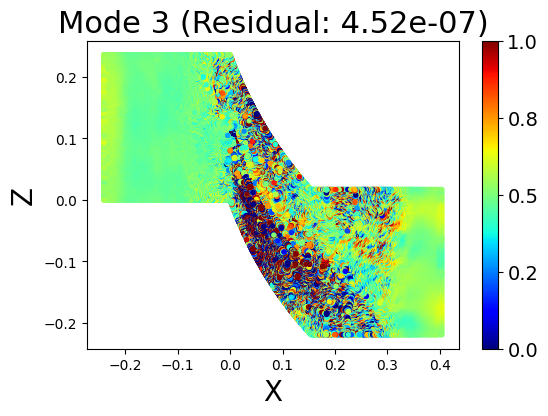

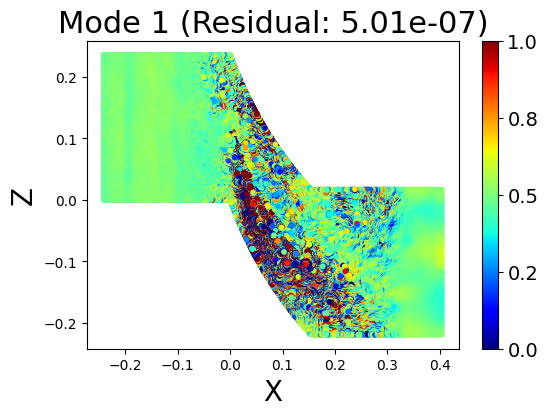

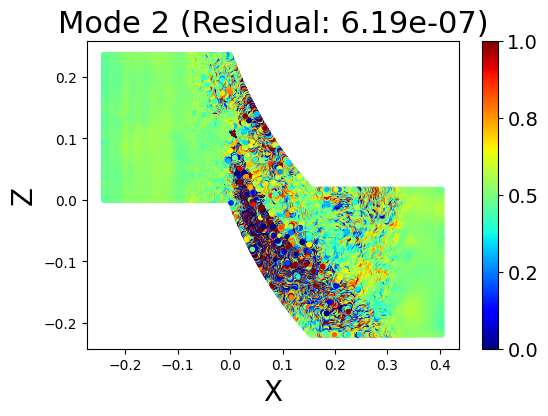

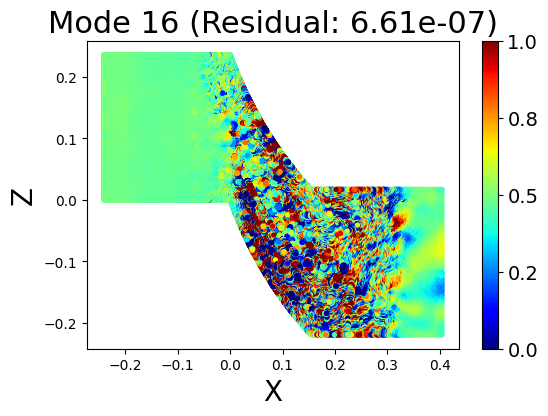

In [17]:
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import h5py

# Load spatial data
with h5py.File('pressure_data.mat', 'r') as file:
    X_data = np.array(file['X_data']).flatten()
    Z_data = np.array(file['Z_data']).flatten()



# Calculate residues for each mode
print("Calculating residues...")
residues = np.zeros(len(eigenvalues))
for i in tqdm(range(len(eigenvalues))):
    efuns_X_i = eigenfunctions[:, i]
    efuns_Y_i = A_tilde @ efuns_X_i
    lambda_i = eigenvalues[i]
    res_i = np.linalg.norm(efuns_Y_i - lambda_i * efuns_X_i) / np.linalg.norm(efuns_X_i)
    residues[i] = res_i

# Indices of the 4 modes with the smallest residues
selected_indices = np.argsort(residues)[:4]

# Iterate over selected indices and plot each Koopman mode separately
for index in selected_indices:
    # Create a new figure for each Koopman mode
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Extract real part of the Koopman mode
    mode = np.real(koopman_modes[:, index])
    
    # Get the residue value for the current mode
    residue_value = residues[index]
    
    # Create a scatter plot with the original data for coloring
    im = ax.scatter(X_data, Z_data, c=mode, s=15, cmap='jet', edgecolor='none')
    
    # Set title, labels for the plot with larger fonts
    ax.set_title(f'Mode {index + 1} (Residual: {residue_value:.2e})', fontsize=22)
    ax.set_xlabel('X', fontsize=20)
    ax.set_ylabel('Z', fontsize=20)  # Fixed to match X Data font size
    
    # Adjust color limits to 10th and 90th percentiles for better contrast
    lower_lim = np.percentile(mode, 10)
    upper_lim = np.percentile(mode, 90)
    im.set_clim(lower_lim, upper_lim)
    
    # Create a normalized colorbar with values from 0 to 1
    cbar = fig.colorbar(im, ax=ax)
    
    # Set custom ticks for the colorbar to show 0-1 range
    tick_positions = np.linspace(lower_lim, upper_lim, 5)  # 5 positions between data limits
    normalized_ticks = np.linspace(0, 1, 5)  # 5 values from 0 to 1
    
    cbar.set_ticks(tick_positions)
    cbar.set_ticklabels([f'{val:.1f}' for val in normalized_ticks])
    
    # Make tick labels larger on the colorbar
    cbar.ax.tick_params(labelsize=14)
    
    # Save the figure with a filename indicating the index of the Koopman mode
    # Uncomment the following line if you want to save the figure
    fig.savefig(f'koopman_mode_hankeldmd_{index + 1}.png', bbox_inches='tight')
    
    # Show the figure
    plt.show()
